# Προηγμένα Θέματα Ανάλυσης Δεδομένων (2023-2024)
# **Παναγιώτης Μόσχος - e18186**
### Recomendation System (https://grouplens.org/datasets/movielens/): ml-latest-small.zip (size: 1 MB)

Σε αυτό το αρχείο γίνεται μια προσπάθεια δημιουργίας ενός συστήματος προτάσεων βασιζόμενων στο περιεχόμενο.


1.   Αρχικά, θα προσπαθήσουμε να μελετήσουμε και να προετοιμάσουμε τα δεδομένα μας.

2.   Στη συνέχεια θα επιλέξουμε έναν τυχαίο χρήστη και θα προσπαθήσουμε να δημιουργήσουμε ένα σύστημα προτάσεων για αυτόν.

3.   Τέλος, θα προσπαθήσουμε να γενικεύσουμε το μοντέλο μας δημιουργώντας μια συνάρτηση η οποία θα λαμβάνει το σύνολο των δεδομένων, το id του επιθυμητού χρήστη καθώς και τον αριθμό των προβλέψεων που θέλουμε να μας επιστρέψει και θα εκτυπώνει τα συγκερκιμένα αποτελέσματα.





## Content based Recommendation System

In [112]:
# Κάνω Import τις απαραίτητες βιβλιοθήκες
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
# Δημιουργώ dataframes για τις movies και τα ratins
# Αυτά είναι τα δεδομένα που χρειάζομαι για να εργαστώ και να δημιουργήσω το recommendation system
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

In [114]:
# Αρχικά μελετώ τα δεδομένα των Movies
print("Movies Dataset")
movies_df.head()

Movies Dataset


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [115]:
print("The shape of movies dataframe:", movies_df.shape)

The shape of movies dataframe: (9742, 3)


In [116]:
print("Unique movies by id:", movies_df.movieId.nunique())

Unique movies by id: 9742


In [117]:
print("Unique movies by title:", movies_df.title.nunique())

Unique movies by title: 9737


In [118]:
# Παρατηρούμε ότι υπάρχει διαφορά ανάμεσα στις δυο παραπάνω ποσότητες, πράγμα που οδηγεί
# στο συμπέρασμα ότι κάποιες ταινίες ενώ έχουν τον ίδιο τίτλο έχουν διαφορετικό id.
# Συνεπώς, μάλλον πρόκειται για διπλές καταχωρήσεις.
# Αυτό το λάθος θα πρέπει να διοθρωθεί στη συνέχεια για 9742 - 9737 = 5 περιπτώσεις.

In [119]:
# Μελετώ τα δεδομένα των Ratings
print("Ratings Dataset")
ratings_df.head()

Ratings Dataset


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [120]:
print("The shape of ratings dataframe:", ratings_df.shape)

The shape of ratings dataframe: (100836, 4)


In [121]:
print('Unique ratings by movie id:', ratings_df.movieId.nunique())

Unique ratings by movie id: 9724


In [122]:
print("Unique ratings by user id:", ratings_df.userId.nunique())

Unique ratings by user id: 610


In [123]:
# Συνεπώς έχουμε 610 χρήστες οι οποίοι έχουν πραγματοποίσει
# συνολικά 9.927 κριτικές.

In [124]:
# getting the ids of a movie
movies_df[movies_df['title'] == 'Saturn 3 (1980)']

,movieId,title,genres
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


### Διόρθωση της αναντιστοιχίας μεταξύ "movieId" και "titles"

In [125]:
# Βρίσκω τους τίτλους των τανιών οι οποίες έχουν καταχωρηθεί 2 φορές,
# δηλαδή τις ταινίες που έχουν τον ίδιο τίτλο αλλά διαφορετικό id.
movies_df.title.value_counts().sort_values(ascending=False).head(10)

Emma (1996)                               2
Confessions of a Dangerous Mind (2002)    2
Eros (2004)                               2
Saturn 3 (1980)                           2
War of the Worlds (2005)                  2
Tom and Huck (1995)                       1
Richard III (1995)                        1
Four Rooms (1995)                         1
Grumpier Old Men (1995)                   1
Waiting to Exhale (1995)                  1
Name: title, dtype: int64

In [126]:
# Εκτυπώνω τους τίτλους των ταινιών τις οποίες πρέπει να επιμεληθώ:
duplicates = movies_df['title'].value_counts()
duplicates = duplicates[duplicates > 1].sort_values(ascending=False)

print(duplicates)

Emma (1996)                               2
War of the Worlds (2005)                  2
Confessions of a Dangerous Mind (2002)    2
Eros (2004)                               2
Saturn 3 (1980)                           2
Name: title, dtype: int64


In [127]:
# Eκτυπώνω μόνο τα ονόματα των ταινιών που έχουν διπλή καταχώρηση id.
import re

def remove_year_from_title(title):
    return re.sub(r'\s\(\d{4}\)$', '', title)

duplicate_movies_list = duplicates.index.tolist()
duplicate_movies_list
print(duplicate_movies_list)

['Emma (1996)', 'War of the Worlds (2005)', 'Confessions of a Dangerous Mind (2002)', 'Eros (2004)', 'Saturn 3 (1980)']


In [128]:
# Κάνω την εξής εκτύπωση για να πάρω τα id αυτών των ταινιών και να ελέγξω και
# για τυχόν άλλες διαφορές π.χ. στη στήλη genres
for name in duplicate_movies_list:
  print(movies_df[movies_df['title'] == name])


      movieId        title                genres
650       838  Emma (1996)  Comedy|Drama|Romance
5601    26958  Emma (1996)               Romance
      movieId                     title                            genres
5931    34048  War of the Worlds (2005)  Action|Adventure|Sci-Fi|Thriller
6932    64997  War of the Worlds (2005)                     Action|Sci-Fi
      movieId                                   title  \
4169     6003  Confessions of a Dangerous Mind (2002)   
9106   144606  Confessions of a Dangerous Mind (2002)   

                                   genres  
4169          Comedy|Crime|Drama|Thriller  
9106  Comedy|Crime|Drama|Romance|Thriller  
      movieId        title         genres
5854    32600  Eros (2004)          Drama
9135   147002  Eros (2004)  Drama|Romance
      movieId            title                     genres
2141     2851  Saturn 3 (1980)  Adventure|Sci-Fi|Thriller
9468   168358  Saturn 3 (1980)            Sci-Fi|Thriller


Άρα, θα πρέπει να αποφασίσω ποιά από τις 2 καταχωρήσεις σε κάθε περίπτωση θα κρατήσω.
Σε κάθε περίπτωση, τελικά θα κρατήσω την εγγραφή η οποία θα έχει τις περισσότερες εγγραφές.

Επειδή οι εγγραφές αυτές πάνω στις οποίες θα εργαστώ είναι μόνο 5 θα κάνω τις αλλαγές
ξεχωριστά για την κάθε μια. Αν ήταν περισσότερες θα δημιουργούσα μια συνάρτηση.

In [129]:
# Αρχικά ελέγχω τον αριθμό των εγγραφών για το κάθε id.
print(ratings_df[(ratings_df['movieId'] == 838) | (ratings_df['movieId'] == 26958)]['movieId'].value_counts())
print(ratings_df[(ratings_df['movieId'] == 34048) | (ratings_df['movieId'] == 64997)]['movieId'].value_counts())
print(ratings_df[(ratings_df['movieId'] == 6003) | (ratings_df['movieId'] == 144606)]['movieId'].value_counts())
print(ratings_df[(ratings_df['movieId'] == 32600) | (ratings_df['movieId'] == 147002)]['movieId'].value_counts())
print(ratings_df[(ratings_df['movieId'] == 2851) | (ratings_df['movieId'] == 168358)]['movieId'].value_counts())

838      30
26958     1
Name: movieId, dtype: int64
34048    50
64997     2
Name: movieId, dtype: int64
6003      15
144606     1
Name: movieId, dtype: int64
147002    1
32600     1
Name: movieId, dtype: int64
2851      4
168358    1
Name: movieId, dtype: int64


In [130]:
# Άρα, θα διαγράφω τις εγγραφές με id: 168358, 144606, 26958, 64997 και 147002
movies_df = movies_df[movies_df['movieId'] != 168358]
movies_df = movies_df[movies_df['movieId'] != 144606]
movies_df = movies_df[movies_df['movieId'] != 26958]
movies_df = movies_df[movies_df['movieId'] != 64997]
movies_df = movies_df[movies_df['movieId'] != 147002]

## Συγχωνεύω τώρα τα δεδομένα των Movies και των Ratings σε ένα ενιαίο Dataframe με βάσει το πεδίο movieId.

In [131]:
# Συγχώνευση των dataframes
movie_ratings_df = pd.merge(movies_df, ratings_df, on='movieId')
movie_ratings_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [132]:
# Ελέγχω το movie_ranting_df shape
print(movie_ratings_df.shape)

(100830, 6)


In [134]:
# Η στήλη timestamp στη συγκεκριμένη μελέτη δεν θα μου χρειαστεί.
# Ενδεχομένως σε μια μελλοντική επέκταση της εφαρμογής να λαμβάναμε υπόψη μόνο τις πρόσφατες
# κριτικές π.χ. του τελευταίου έτους κτλ

movie_ratings_df = movie_ratings_df[['userId','movieId', 'title', 'genres', 'rating']]
movie_ratings_df.head()

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
2,7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5
3,15,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5
4,17,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5


In [136]:
# Για διευκόλυνση θα ταξινομήσω το dataframe μου πρώτα κατά βάση userId και έπειτα κατά βάση movieId
# οπότε έτσι έχω καλύτερη εικόνα για τις ταινίες που έχει βαθμολογήσει ο κάθε χρήστης
movie_ratings_df.sort_values(['userId','movieId'], inplace=True)
movie_ratings_df.head()

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
325,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0
433,1,6,Heat (1995),Action|Crime|Thriller,4.0
2107,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0
2379,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0


In [139]:
# κάνω index reset για να βλέπω τέρμα αριστερά την τρέχουσα σειρά των εγγγραφών
movie_ratings_df.reset_index(drop=True, inplace=True)
movie_ratings_df.head()

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0
2,1,6,Heat (1995),Action|Crime|Thriller,4.0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0


In [143]:
# Ανακεφαλαιώνοντας...
print("Number of unique users:", movie_ratings_df.userId.nunique())
print("Number of unique moviesbased on their id:", movie_ratings_df.movieId.nunique())
print("Numbe of unique movies based on their title:", movie_ratings_df.title.nunique())

Number of unique users: 610
Number of unique moviesbased on their id: 9719
Numbe of unique movies based on their title: 9719


In [144]:
# Μορφοποιώ λίγο καλύτερα τα δεδομένα του πίνακα

# 1. Αφαιρώ τυχόν κενά από titles και genres
movie_ratings_df['title'] = movie_ratings_df['title'].str.strip()
movie_ratings_df['genres'] = movie_ratings_df['genres'].str.strip()

# 2. Προσθέτω το έτος της κάθε ταινίας σε ξεχωριστή στήλη στο dataframe με όνομα year
movie_ratings_df['year'] = movie_ratings_df['title'].str[-5:-1]

In [145]:
movie_ratings_df.head()

,userId,movieId,title,genres,rating,year
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0,1995
2,1,6,Heat (1995),Action|Crime|Thriller,4.0,1995
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,1995
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,1995


In [146]:
# Εξάγω τα έτη των ταινιών
movie_ratings_df.year.unique()

array(['1995', '1996', '1994', '1977', '1993', '1990', '1989', '1991',
       '1940', '1939', '1941', '1938', '1947', '1975', '1968', '1945',
       '1963', '1971', '1951', '1979', '1992', '1986', '1982', '1980',
       '1987', '1981', '1983', '1960', '1952', '1984', '1933', '1985',
       '1974', '1922', '1997', '1998', '1930', '1976', '1942', '1967',
       '1959', '1946', '1978', '1973', '1988', '1999', '1931', '1964',
       '1962', '1965', '1969', '2000', '1970', '2003', '2004', '2006',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '1955', '2002', '1961', '1954', '1957', '1943', '1956', '1966',
       '2001', '1937', '1972', '2005', '1950', '2007', '2016', '1926',
       '1944', '1949', '1936', '2017', '1958', '1935', '1927', '1953',
       '2018', '1923', '1902', '1920', '1948', '1928', 'irro', '1934',
       '1916', '1908', '1932', '1921', '1925', '1929', '1917', 'atso',
       ' Bab', 'ron ', '1915', '1924', '1903', 'r On', 'lon ', '1919',
      

Παρατηρώ ότι σε μερικές ταινίες τα 4 τελευταία γράμματα δεν ήταν χρονολογία αλλά γράμματα

In [148]:
# Μετράω τον αριθμό των ταινιών που έχουν τις συγκεκριμένες συμβολοσειρές αντί για χρονολογία
# Count the rows containing specific substrings
count_irro = movie_ratings_df['year'].str.contains('irro').sum()
count_atso = movie_ratings_df['year'].str.contains('atso').sum()
count_Bab = movie_ratings_df['year'].str.contains(' Bab').sum()
count_ron = movie_ratings_df['year'].str.contains('ron ').sum()
count_r_On = movie_ratings_df['year'].str.contains('r On').sum()
count_lon = movie_ratings_df['year'].str.contains('lon ').sum()
count_imal = movie_ratings_df['year'].str.contains('imal').sum()
count_osmo = movie_ratings_df['year'].str.contains('osmo').sum()
count_he_O = movie_ratings_df['year'].str.contains('he O').sum()
count_Roa = movie_ratings_df['year'].str.contains(' Roa').sum()
count_ligh = movie_ratings_df['year'].str.contains('ligh').sum()
count_erso = movie_ratings_df['year'].str.contains('erso').sum()

# Print the counts
print("Count of 'irro':", count_irro)
print("Count of 'atso':", count_atso)
print("Count of ' Bab':", count_Bab)
print("Count of 'ron ':", count_ron)
print("Count of 'r On':", count_r_On)
print("Count of 'lon ':", count_lon)
print("Count of 'imal':", count_imal)
print("Count of 'osmo':", count_osmo)
print("Count of 'he O':", count_he_O)
print("Count of ' Roa':", count_Roa)
print("Count of 'ligh':", count_ligh)
print("Count of 'erso':", count_erso)


Count of 'irro': 1
Count of 'atso': 1
Count of ' Bab': 1
Count of 'ron ': 1
Count of 'r On': 4
Count of 'lon ': 2
Count of 'imal': 1
Count of 'osmo': 2
Count of 'he O': 1
Count of ' Roa': 1
Count of 'ligh': 1
Count of 'erso': 1


Παρατηρώ ότι αυτά τα ratings είναι λίγα σε αριθμό, άρα μπορώ να τα "πετάξω" χωρίς να υπάρξει μεγάλη βλάβη της γενικότητας.

In [149]:
# θα κάνω drop τις εγγαφές στις οποίες αντί για έτος έχω συμβολοσειρά
strings_to_drop = ['irro', 'atso', ' Bab', 'ron ', 'r On', 'lon ', 'imal', 'osmo', 'he O', ' Roa', 'ligh', 'erso']

for string in strings_to_drop:
    movie_ratings_df = movie_ratings_df[~movie_ratings_df['year'].str.contains(string)]

In [151]:
# Το νέο shape του dataframe μου είναι
movie_ratings_df.shape

(100813, 6)

#### Από το Readme αρχείο του dataset παρατηρώ ότι έχω κάποιες ταινίες που αντί για genre έχουν το: (no genres listed).

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [155]:
# ΑΦαιρώ (drop) τις εγγραφές που έχουν ως genre το (no genres listed)

movie_ratings_df[movie_ratings_df['genres']=='(no genres listed)'].drop_duplicates('movieId')['movieId'].count()

26

Παρατηρώ ότι 26 εγγραφές είναι που έχουν ως genre: (no genres listed)
Σε μια εναλλακτική προσέγγιση, θα μπορούσα να εντοπίσω τα genres των συγκεκριμένων ταινιών και να τα προσθέσω ένα ένα.

Παρόλ' αυτά τα κάνω drop χωρίς βλάβη της γενικότητας.

In [156]:
# Αφαιρώ τις εγγραφές όπου ως genres έχουν: (no genres listed)
movie_ratings_df = movie_ratings_df[movie_ratings_df['genres'] != "(no genres listed)"]
movie_ratings_df.shape

(100775, 6)

Παρατηρώ ότι το σχήμα μου από: (100813, 6) έγινε τώρα (100775, 6) καθώς έγιναν drop 26 εγγραφές.

In [161]:
# Τσεκάρω τον τύπο δεδομένων της στήλης year που δημιούγησα
year_column_type = movie_ratings_df['year'].dtype
print(year_column_type)

object


In [162]:
# Μετατρέπω τις τιμές της στήλης year σε int
movie_ratings_df['year'] = movie_ratings_df['year'].astype(int)

In [164]:
# Τσεκάρω τον τύπο δεδομένων της στήλης year που δημιούγησα
year_column_type = movie_ratings_df['year'].dtype
print(year_column_type)

int64


In [166]:
# Ανακεφαλαιώνοντας μέχρι το σημείο αυτό, ρίχνω μια ματιά στο Dataframe μέχρι στιγμής
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100775 entries, 0 to 100829
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100775 non-null  int64  
 1   movieId  100775 non-null  int64  
 2   title    100775 non-null  object 
 3   genres   100775 non-null  object 
 4   rating   100775 non-null  float64
 5   year     100775 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [167]:
movie_ratings_df.head()

,userId,movieId,title,genres,rating,year
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0,1995
2,1,6,Heat (1995),Action|Crime|Thriller,4.0,1995
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,1995
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,1995


### Genres Column
Τώρα θα πρέπει να εργαστούμε με τη στήλη genres.


1.   Θα πρέπει να διαχωριστούν τα genres κάθε ταινίας με βάση το διαχωριστικό |

2.   Έπειτα θα πρέπει να βρούμε τα είδη των genres που περιέχονται γενικά στο σύνολο των δεδομένων μας.
3. Τέλος, θα πρέπει να δημιουργήσουμε σε κάθε εγγραφή (row) μια στήλη με το κάθε μοναδικό genre και να τοποθετήσουμε σε αυτό 0 (αν το genre αυτό δεν συμπεριλαμβάνεται στην εν λόγω ταινία) ή 1 (αν το genre αυτό συμπεριλαμβάνεται στην συγκεκριμένη ταινία).

In [168]:
# Βήμα 1
genre_df = movie_ratings_df[['genres']]

# split
genre_df = genre_df['genres'].str.split('|', expand=True)

In [169]:
# Τσεκάρω (εκτυπώνω τo genre_df)
genre_df.head()

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,Comedy,Romance,None,None,None,None,None,None,None,None
2,Action,Crime,Thriller,None,None,None,None,None,None,None
3,Mystery,Thriller,None,None,None,None,None,None,None,None
4,Crime,Mystery,Thriller,None,None,None,None,None,None,None


In [186]:
# Δημιουργώ μια συνάρτηση η οποία θα επιστρέψει τα μοναδικά genre
# def genre_name(dataframe):
#     unique_values = set()
#     for column in dataframe.columns:
#         unique_values.update(dataframe[column].unique())
#     return unique_values

def genre_name(dataframe):
    df = dataframe.copy()
    col = df.columns
    u = set()
    for i in col:
        s = set(df[i].value_counts().index)
        u = u.union(s)
    return(u)

In [187]:
# Τσεκάρω τα genres που που επιστρέφει η κλήση της συνάρτησης που έφτιαξα
gens = genre_name(genre_df)
gens

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [188]:
# To genre_df δεν θέλω να περιέχει None
# Αντικαθιστώ όλα τα None με 0 και όπου υπάρχει τιμή με 1
for genre in gens:
    movie_ratings_df[genre] = movie_ratings_df['genres'].apply(lambda x: 1 if genre in x else 0)

In [189]:
movie_ratings_df.head()

,userId,movieId,title,genres,rating,year,Fantasy,Children,Mystery,Film-Noir,...,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0,1995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,6,Heat (1995),Action|Crime|Thriller,4.0,1995,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,1995,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,1995,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Πριν προχωρήσω στη δημιουργία του μοντέλου μου θα δημιουργήσω μερικές γραφικές αναπαραστάσεις για να έχω μια καλύτερη εικόνα των δεδομένων

π.χ. πώς κατανέμονται οι κριτικές (η συχνότητά τους)

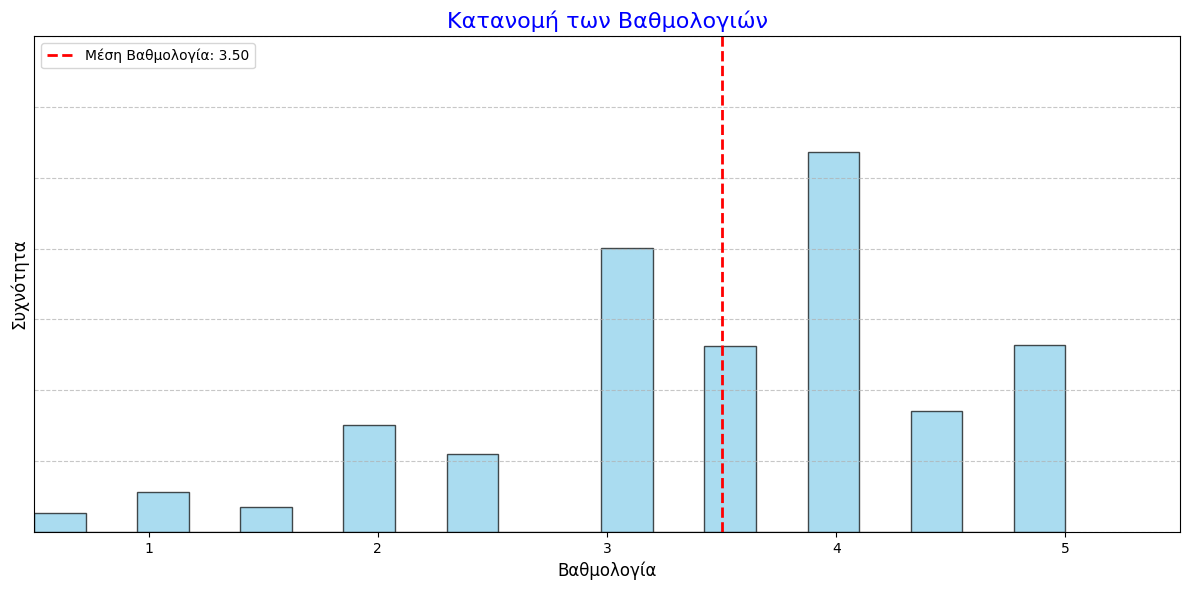

In [192]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Ορισμός του σχήματος και των αξόνων
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Σχεδίαση ιστογράμματος
plt.hist(movie_ratings_df['rating'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Κατακόρυφη γραμμή για τη μέση βαθμολογία
μέση_βαθμολογία = movie_ratings_df['rating'].mean()
plt.axvline(x=μέση_βαθμολογία, color='red', linestyle='--', linewidth=2, label=f'Μέση Βαθμολογία: {μέση_βαθμολογία:.2f}')

# X,Y-label names
plt.xlabel('Βαθμολογία', fontsize=12)
plt.ylabel('Συχνότητα', fontsize=12)
plt.title('Κατανομή των Βαθμολογιών', fontsize=16, color='blue')

# Ορισμός ορίων για τους άξονες x και y
plt.xlim(0.5, 5.5)
plt.ylim(0, 35000)

# Προσθήκη legend
plt.legend(loc='upper left', fontsize=10)

plt.tick_params(axis='y', which='both', left=False, labelleft=False)
# Προσθήκη πλέγματος για καλύτερη αναφορά στην κατανομή της συχνότητας
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ρύθμιση διάταξης
plt.tight_layout()

# Εμφάνιση γραφήματος
plt.show()



Επίσης, ενδιαφέρον παρουσιάζει να δούμε το ποσοστό των κριτικών που έχουν δοθεί ανά genre.

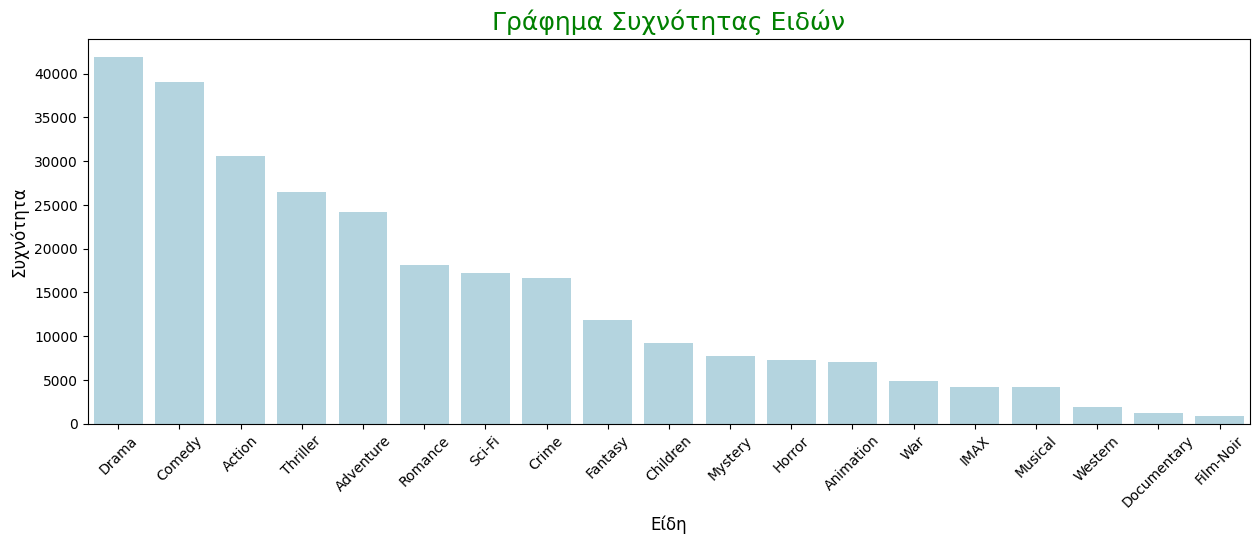

In [193]:
# Υπολογισμός συνολικού αριθμού εμφάνισης κάθε είδους
genres_count = movie_ratings_df.iloc[:, 6:].sum(axis=0).reset_index().rename(columns={'index': 'genre', 0: 'count'})
genres_count.sort_values('count', ascending=False, inplace=True)

# Δημιουργία του γραφήματος
plt.figure(figsize=(15, 5))
sns.barplot(x=genres_count['genre'], y=genres_count['count'], color='lightblue')

# Περιστροφή των ετικετών στον άξονα x για καλύτερη αναγνωσιμότητα
plt.xticks(rotation=45)

# Ορισμός ετικέτας για τον άξονα x και κεντράρισμα της ετικέτας
plt.xlabel('Είδη', size=12)
plt.ylabel('Συχνότητα', size=12)

# Ορισμός τίτλου και αλλαγή του χρώματος
plt.title('Γράφημα Συχνότητας Ειδών', size=18, color='green')

# Εμφάνιση του γραφήματος
plt.show()


Παρατηρούμε ότι οι κατηγορίες Drama, Comedy, Action, Thriller και Adventure έχουν λάβει τον μεγαλύτερο αριθμό κριτικών.

Φυσικά θα μπορούσαν να δημιουργηθούν και άλλα γραφήματα που να οπτικοποιούν ενδιαφέρουσες πληροφορίες του dateset μας. (σε μελλοντική επέκταση της εργασίας)

## Content Based Recommendation System

Θα ακολουθήσουμε την προσέγγιση που περιγράψαμε στην αρχή της άσκησης.
Δηλαδή, αρχικά θα δημιουργήσουμε ένα σύστημα προτάσεων για έναν τυχαίο χρήστη και στη συνέχεια θα προσπαθήσουμε να γενικεύσουμε την προσέγγισή μας κατασκευάζοντας μια συνάρτηση η οποία θα λειτουργεί πιο γενικά.

## 1. Δημιουργία μοντέλου για μια ειδική περίπτωση (για έναν τυχαίο χρήστη)




In [286]:
# Λαμβάνουμε τα δεδομένα για τον χρήστη με id: 555 και δημιουργούμε ένα ξεχωριστό dataframe
user555_df = movie_ratings_df[movie_ratings_df['userId']==555]
user555_df.head()

,userId,movieId,title,genres,rating,year,Fantasy,Children,Mystery,Film-Noir,...,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
85285,555,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
85286,555,3,Grumpier Old Men (1995),Comedy|Romance,5.0,1995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
85287,555,19,Ace Ventura: When Nature Calls (1995),Comedy,3.0,1995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85288,555,21,Get Shorty (1995),Comedy|Crime|Thriller,4.0,1995,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
85289,555,24,Powder (1995),Drama|Sci-Fi,5.0,1995,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [287]:
# Τυπώνω το shape για να δω αν έχω αρκετά δεδομένα για τον χρήστη που διάλεξα τυχαία
user555_df.shape

(578, 25)

In [288]:
# 1. Λαμβάνω τα ratings του συγκεκριμένου χρήστη
user555_ratings_df = user555_df['rating']
user555_ratings_df.head()

85285    4.0
85286    5.0
85287    3.0
85288    4.0
85289    5.0
Name: rating, dtype: float64

In [289]:
# 2. Λαμβάνω τον πίνακα με τις ταινίες
user555_movie_df = user555_df.iloc[:,6:]
user555_movie_df.head()

,Fantasy,Children,Mystery,Film-Noir,Horror,Musical,Comedy,IMAX,Thriller,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
85285,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
85286,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
85287,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
85288,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
85289,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [290]:
# 3. Πολλαπλασιάζω τους παραπάνω 2 πίνακες προκειμένου να λάβω τον user555_movie_df αλλά με τα σωστά βάρη (ανάλογα με τις κριτικές)
user555_movie_weights_df = user555_movie_df.multiply(user555_ratings_df, axis = 0)
user555_movie_weights_df.head()

,Fantasy,Children,Mystery,Film-Noir,Horror,Musical,Comedy,IMAX,Thriller,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
85285,4.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0
85286,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
85287,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85288,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
85289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [291]:
# Συνενώνω τους πίνακες user555_df και user555_movie_weights_df
wgn = pd.concat((user555_df.iloc[:,:6], user555_movie_weights_df), axis=1)
wgn.head()

,userId,movieId,title,genres,rating,year,Fantasy,Children,Mystery,Film-Noir,...,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
85285,555,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0
85286,555,3,Grumpier Old Men (1995),Comedy|Romance,5.0,1995,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
85287,555,19,Ace Ventura: When Nature Calls (1995),Comedy,3.0,1995,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85288,555,21,Get Shorty (1995),Comedy|Crime|Thriller,4.0,1995,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
85289,555,24,Powder (1995),Drama|Sci-Fi,5.0,1995,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
# Υπολογίζω τα weights των genres
wg = wgn.iloc[:,6:].sum(axis=0)/wgn.iloc[:,6:].sum(axis=0).sum()
wg

Fantasy        0.032489
Children       0.023629
Mystery        0.022996
Film-Noir      0.001266
Horror         0.050633
Musical        0.008017
Comedy         0.207595
IMAX           0.000844
Thriller       0.089451
Action         0.101688
Documentary    0.000633
Sci-Fi         0.091561
Drama          0.147468
Adventure      0.074262
Western        0.007595
Animation      0.006751
Crime          0.048101
War            0.014768
Romance        0.070253
dtype: float64

In [293]:
# Θα λάβω τώρα όλο το dataset πλην των εγγραφών που αφορούν τον χρήστη 555
foreign_users = movie_ratings_df[movie_ratings_df['userId'] != 555]
foreign_users.head()

,userId,movieId,title,genres,rating,year,Fantasy,Children,Mystery,Film-Noir,...,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0,1995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,6,Heat (1995),Action|Crime|Thriller,4.0,1995,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,1995,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,1995,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Επίσης, θέλω να κρατήσω από το σύνολο των ταινών, μόνο τις ταινίες που δεν έχει δει ο χρήστης με id: 555 καθώς κρίνεται σκόπιμο να μην προτείνουμε στον χρήστη να δει ταινίες που έχει ήδη δει στο παρελθόν.

Για να κάνουμε κάτι τέτοιο θα πρέπει πρώτα να αφαιρέσουμε από το σύνολο των ταινιών τις ταινίες που έχει δει ο χρήστης δημιουργώντας κάποια αρχικά dataset.

In [294]:
# Αποθηκεύουμε στο all_movies_id όλα (1 φορά το καθένα) τα id των ταινιών
all_movies_id = set(movie_ratings_df[movie_ratings_df['userId']==555]['movieId'].values)

# Αποθηκεύουμε στο user_movies_id όλα (1 φορά το καθένα) τα id των ταινιών που έχει δει ο χρήστης
user_movies_id = set(movie_ratings_df.movieId.unique())

# Αφαιρώντας τα 2 παραπάνω σύνολα, βρίσκουμε πολύ εύκολα τα id των ταινιών που δεν έχει δει ο χρήστης
user_unwatched_movie_id = all_movies_id - user_movies_id

# Συνεπώς, μπορώ πλέον να βρω το dataframe το οποίο θα περιέχει όλες τις ταινίες, εκτός από αυτές
# που έχει ήδη παρακολουθήσει ο χρήστης με id 555.
unwatched_movies = foreign_users.copy()
# Κάνω drop τις στήλες userId και rating (σίγουρα δεν τις χρειάζομαι πλέον)
unwatched_movies = unwatched_movies.drop(['userId','rating'], axis=1)
unwatched_movies.head()

,movieId,title,genres,year,Fantasy,Children,Mystery,Film-Noir,Horror,Musical,...,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6,Heat (1995),Action|Crime|Thriller,1995,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [295]:
# Τσεκάρω το σχήμα του νέου dataframe
unwatched_movies.shape

(100197, 23)

In [296]:
# Τσεκάρω το σύνολο των μοναδικών id των ταινιών που έχουν βαθμολογηθεί
unwatched_movies.movieId.nunique()

9668

In [297]:
# Τσεκάρω το σύνολο των μοναδικών title των ταινιών που έχουν βαθμολογηθεί
unwatched_movies.title.nunique()

9668

In [298]:
# Τσεκάρω ότι όσα είναι τα μοναδικά id να είναι τα οι μοναδικοί τίτλοι ταινιών
unwatched_movies.movieId.nunique() == unwatched_movies.title.nunique()

True

In [299]:
# Δημιουργώ τον πίνακα με τα κατάλληλα βάρη
unwatched_movies_with_weights = pd.concat((unwatched_movies.iloc[:,:4], unwatched_movies.iloc[:,4:].multiply(wg)), axis=1)
unwatched_movies_with_weights.head()

,movieId,title,genres,year,Fantasy,Children,Mystery,Film-Noir,Horror,Musical,...,Action,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0.032489,0.023629,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.074262,0.0,0.006751,0.000000,0.0,0.000000
1,3,Grumpier Old Men (1995),Comedy|Romance,1995,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.070253
2,6,Heat (1995),Action|Crime|Thriller,1995,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.101688,0.0,0.0,0.0,0.000000,0.0,0.000000,0.048101,0.0,0.000000
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995,0.000000,0.000000,0.022996,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995,0.000000,0.000000,0.022996,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.048101,0.0,0.000000


In [300]:
# Υπολογισμός συνολικού βαθμολογικού σκορ για κάθε μη παρακολουθημένη ταινία
unwatched_movies_with_weights["final_score"] = unwatched_movies_with_weights.iloc[:, 4:].sum(axis=1)

# Ταξινόμηση του DataFrame με βάση το τελικό σκορ, με φθίνουσα σειρά
unwatched_movies_with_weights.sort_values('final_score', ascending=False, inplace=True)

In [273]:
unwatched_movies_with_weights.head()

,movieId,title,genres,year,Fantasy,Children,Mystery,Film-Noir,Horror,Musical,...,Documentary,Sci-Fi,Drama,Adventure,Western,Animation,Crime,War,Romance,final_score
29896,81132,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,2010,0.0,0.0,0.022996,0.001266,0.050633,0.0,...,0.0,0.0,0.147468,0.074262,0.007595,0.0,0.048101,0.0,0.000000,0.751055
100463,81132,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,2010,0.0,0.0,0.022996,0.001266,0.050633,0.0,...,0.0,0.0,0.147468,0.074262,0.007595,0.0,0.048101,0.0,0.000000,0.751055
50439,4956,"Stunt Man, The (1980)",Action|Adventure|Comedy|Drama|Romance|Thriller,1980,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.147468,0.074262,0.000000,0.0,0.000000,0.0,0.070253,0.690717
59882,4956,"Stunt Man, The (1980)",Action|Adventure|Comedy|Drama|Romance|Thriller,1980,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.147468,0.074262,0.000000,0.0,0.000000,0.0,0.070253,0.690717
36046,4956,"Stunt Man, The (1980)",Action|Adventure|Comedy|Drama|Romance|Thriller,1980,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.147468,0.074262,0.000000,0.0,0.000000,0.0,0.070253,0.690717


In [305]:
# Εκτυπώνω τις 10 ταινίες που θα προτείνω στον χρήστη με id 555 να δει στο μέλλον

filtered_movies = unwatched_movies_with_weights[unwatched_movies_with_weights["genres"].str.contains("|", regex=False)]

sorted_movies = filtered_movies.sort_values(by='final_score', ascending=False)

top_10_recommended_movies = sorted_movies.head(10)

unique_top_10_movies_titles = set(top_10_recommended_movies['title'])

In [306]:
unique_top_10_movies_titles

{'Osmosis Jones (2001)', 'Rubber (2010)', 'Stunt Man, The (1980)'}

## 2. Δημιουργία μοντέλου για γενική χρήση

In [311]:
def recommend_movies_for_user(movie_ratings_df, user_id):
    # Step 1: Filter for the specified user and calculate weights
    user_df = movie_ratings_df[movie_ratings_df['userId'] == user_id]
    user_ratings_df = user_df['rating']
    user_movie_df = user_df.iloc[:, 6:]
    user_movie_weights_df = user_movie_df.multiply(user_ratings_df, axis=0)
    wgn = pd.concat((user_df.iloc[:, :6], user_movie_weights_df), axis=1)
    wg = wgn.iloc[:, 6:].sum(axis=0) / wgn.iloc[:, 6:].sum(axis=0).sum()

    all_movies_id = set(movie_ratings_df[movie_ratings_df['userId'] == user_id]['movieId'].values)
    user_movies_id = set(movie_ratings_df['movieId'].unique())
    user_unwatched_movie_id = user_movies_id - all_movies_id
    foreign_users = movie_ratings_df[movie_ratings_df['userId'] != user_id]
    unwatched_movies = foreign_users[foreign_users['movieId'].isin(user_unwatched_movie_id)].drop(['userId', 'rating'], axis=1)

    unwatched_movies_with_weights = pd.concat((unwatched_movies.iloc[:, :4], unwatched_movies.iloc[:, 4:].multiply(wg, axis=1)), axis=1)
    unwatched_movies_with_weights["final_score"] = unwatched_movies_with_weights.iloc[:, 4:].sum(axis=1)
    unwatched_movies_with_weights.sort_values('final_score', ascending=False, inplace=True)

    filtered_movies = unwatched_movies_with_weights[unwatched_movies_with_weights["genres"].str.contains("|", regex=False)]
    sorted_movies = filtered_movies.sort_values(by='final_score', ascending=False)
    top_10_recommended_movies = sorted_movies.head(10)
    unique_top_10_movies_titles = set(top_10_recommended_movies['title'])

    return unique_top_10_movies_titles


In [312]:
print(recommend_movies_for_user(movie_ratings_df, 555))

{'Stunt Man, The (1980)', 'Osmosis Jones (2001)', 'Rubber (2010)'}
